In [34]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf
import netCDF4 as nc
import warnings
import pyart
import tqdm
import metpy.calc as mpcalc
import glob
import pandas as pd

def calc_grad_theta(theta):
    
    theta_np = theta.values
    dx, dy = mpcalc.lat_lon_grid_deltas(theta.XLONG.values, theta.XLAT.values)
    dtheta_dy, dtheta_dx = mpcalc.gradient(theta_np, deltas=[dy.to("km"), dx.to("km")])
    grad_theta = dtheta_dy + dtheta_dx
    grad_theta = xr.DataArray(grad_theta.data,dims=["south_north","west_east"])
    grad_theta["XLONG"] = theta.XLONG
    
    return grad_theta

def load_era5(t):
    #Load ERA5
    era5_u = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/10u/2023/10u_era5_oper_sfc_20231001-20231031.nc")
    era5_v = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/10v/2023/10v_era5_oper_sfc_20231001-20231031.nc")

    step=2
    lon_slice = slice(140,165)
    lat_slice = slice(-30,-40)
    era5_u_slice = era5_u.sel(time=t,longitude=lon_slice,latitude=lat_slice).coarsen({"longitude":step,"latitude":step},boundary="trim").mean()
    era5_v_slice = era5_v.sel(time=t,longitude=lon_slice,latitude=lat_slice).coarsen({"longitude":step,"latitude":step},boundary="trim").mean()
    
    return era5_u_slice, era5_v_slice

def load_era5_pl(t,p=850):
    #Load ERA5
    era5_u = xr.open_dataset("/g/data/rt52/era5/pressure-levels/reanalysis/u/2023/u_era5_oper_pl_20231001-20231031.nc").sel(level=p,method="nearest")
    era5_v = xr.open_dataset("/g/data/rt52/era5/pressure-levels/reanalysis/v/2023/v_era5_oper_pl_20231001-20231031.nc").sel(level=p,method="nearest")

    step=2
    lon_slice = slice(150,157)
    lat_slice = slice(-35,-38)
    era5_u_slice = era5_u.sel(time=t,longitude=lon_slice,latitude=lat_slice).coarsen({"longitude":step,"latitude":step},boundary="trim").mean()
    era5_v_slice = era5_v.sel(time=t,longitude=lon_slice,latitude=lat_slice).coarsen({"longitude":step,"latitude":step},boundary="trim").mean()
    
    return era5_u_slice, era5_v_slice


warnings.simplefilter("ignore")

In [2]:
wrflist_d02 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d02*"))]
wrflist_d02_no_mp_heating = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_no_mp_heating/highres_d02*"))]
wrflist_d02_plus = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus/highres_d02*"))]
wrflist_d02_minus = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus/highres_d02*"))]
wrflist_d03 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d03*"))]
wrflist_d04 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_03:00:00"))]

100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


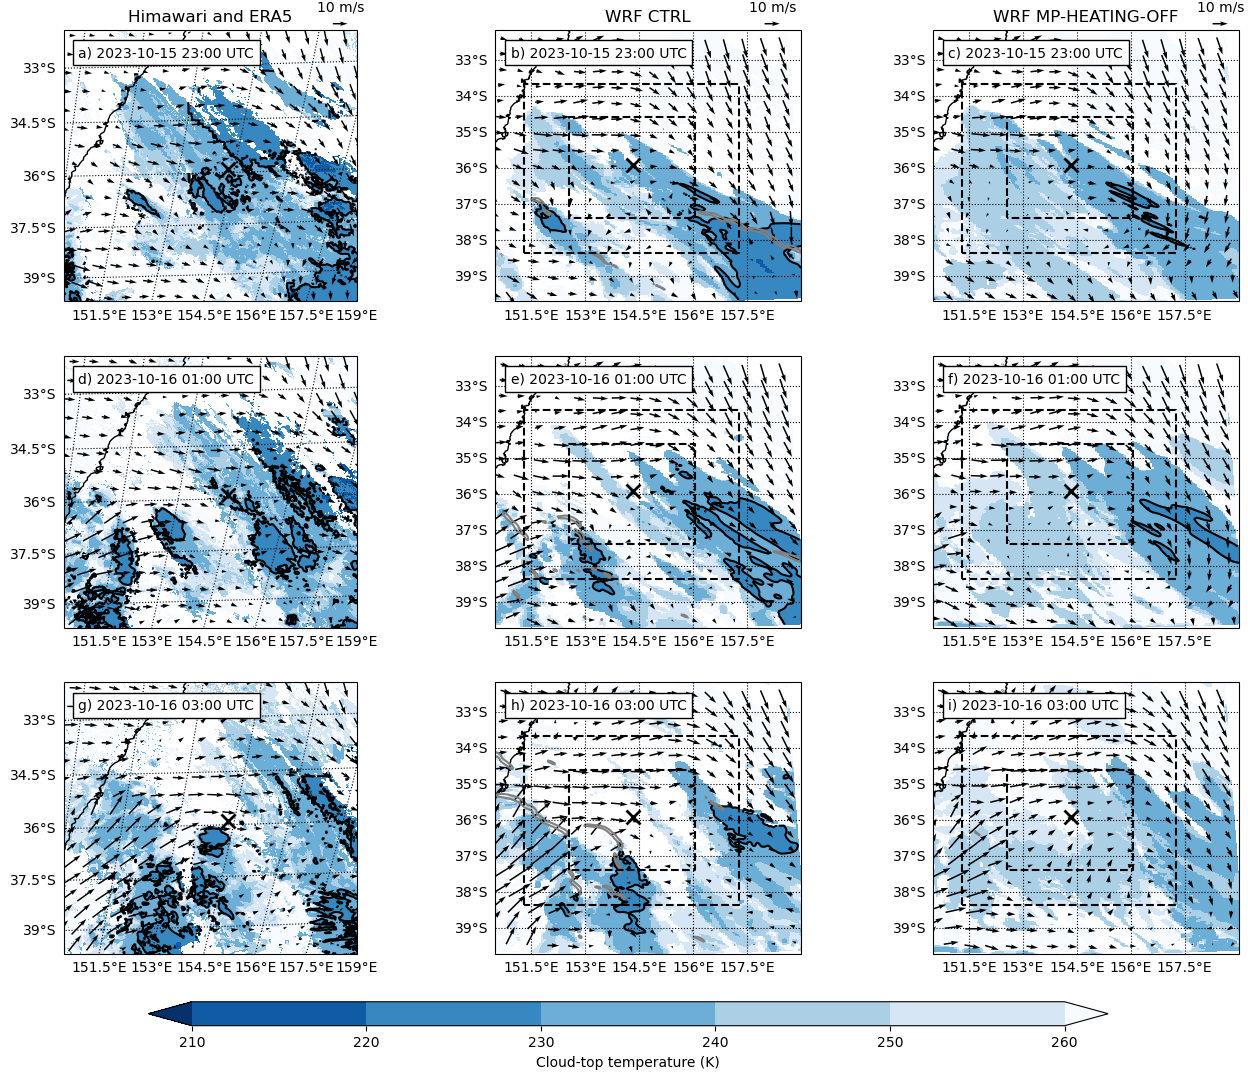

In [47]:
def load_hima(datetime):
    

    obs = xr.open_dataset("/g/data/rv74/satellite-products/arc/der/himawari-ahi/cloud/ctth/v2.0/2023/10/"+datetime.strftime("%d")+"/S_NWC_CTTH_HIMA09_HIMA-N-NR_"+datetime.strftime("%Y%m%dT%H%M%S")+"Z.nc")
    geos_proj = ccrs.Geostationary(central_longitude=obs.attrs["centre_projection_longitude"],satellite_height=35785863)
    ctth_tempe = obs.ctth_tempe.sel(nx=slice(0,3e6),ny=slice(-3e6,-5e6))
    
    return ctth_tempe, geos_proj


plt.figure(figsize = [16,12] )

times = [8,10,12]
cols = 3
ctt_levs = np.linspace(210,260,6)
cnt=0
extents=(150.5,159,-39.71100616455078, -32.152957916259766)
hima_extents=(150.5,157,-39.71100616455078, -32.152957916259766)
letters = ["a","b","c","d","e","f","g","h","i"]
for t in tqdm.tqdm(times):

    #WRF CTRL
    wrflist = wrflist_d02; step = 12
    ax = plt.subplot(len(times), cols, (cnt*cols)+2,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    wrf_proj = wrf.get_cartopy(ctt)
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=ctt_levs,extend="both",add_colorbar=False)
    xr.plot.contour(ctt,ax=ax,colors=["k"],levels=[230],x="XLONG",y="XLAT")
    u10 = uvmet10.coarsen(south_north=step,west_east=step,boundary="trim").mean().isel(u_v=0)
    v10 = uvmet10.coarsen(south_north=step,west_east=step,boundary="trim").mean().isel(u_v=1)
    lat = u10.XLAT
    lon = u10.XLONG
    q2=plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([wrflist_d02[0]["XLONG"][:].min(),wrflist_d02[0]["XLONG"][:].max()])
    plt.ylim([wrflist_d02[0]["XLAT"][:].min(),wrflist_d02[0]["XLAT"][:].max()])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    d03_xlim = [wrflist_d03[0]["XLONG"][:].min(),wrflist_d03[0]["XLONG"][:].max()]
    d03_ylim = [wrflist_d03[0]["XLAT"][:].min(),wrflist_d03[0]["XLAT"][:].max()]    
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.plot([d03_xlim[0],d03_xlim[0],d03_xlim[1],d03_xlim[1],d03_xlim[0]], [d03_ylim[0],d03_ylim[1],d03_ylim[1],d03_ylim[0],d03_ylim[0]], color="k", ls="--")
    #plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)))
    ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    ax.text(0.05,0.9,letters[(cnt*cols)+1]+") "+pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})    
    ax.set_extent(extents)
    if cnt==0:
        plt.title("WRF CTRL")
    else:
        plt.title("")        
    
    #WRF NO MP HEATING
    wrflist = wrflist_d02_no_mp_heating; step = 12
    ax = plt.subplot(len(times), cols, (cnt*cols)+3,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    wrf_proj = wrf.get_cartopy(ctt)
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=ctt_levs,extend="both",add_colorbar=False)
    xr.plot.contour(ctt,ax=ax,colors=["k"],levels=[230],x="XLONG",y="XLAT")
    u10 = uvmet10.coarsen(south_north=step,west_east=step,boundary="trim").mean().isel(u_v=0)
    v10 = uvmet10.coarsen(south_north=step,west_east=step,boundary="trim").mean().isel(u_v=1)
    lat = u10.XLAT
    lon = u10.XLONG
    q3=plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([wrflist_d02[0]["XLONG"][:].min(),wrflist_d02[0]["XLONG"][:].max()])
    plt.ylim([wrflist_d02[0]["XLAT"][:].min(),wrflist_d02[0]["XLAT"][:].max()])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    d03_xlim = [wrflist_d03[0]["XLONG"][:].min(),wrflist_d03[0]["XLONG"][:].max()]
    d03_ylim = [wrflist_d03[0]["XLAT"][:].min(),wrflist_d03[0]["XLAT"][:].max()]    
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.plot([d03_xlim[0],d03_xlim[0],d03_xlim[1],d03_xlim[1],d03_xlim[0]], [d03_ylim[0],d03_ylim[1],d03_ylim[1],d03_ylim[0],d03_ylim[0]], color="k", ls="--")
    #plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)))
    ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    ax.text(0.05,0.9,letters[(cnt*cols)+2]+") "+pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})    
    ax.set_extent(extents)   
    if cnt==0:
        plt.title("WRF MP-HEATING-OFF")
    else:
        plt.title("")
    
    #ERA5 and HIMAWARI
    datetime = pd.to_datetime(wrf.extract_times(wrflist,t))        
    ctth_tempe, geos_proj = load_hima(datetime)
    ax = plt.subplot(len(times), cols, (cnt*cols)+1,projection=geos_proj)
    wrf_proj = wrf.get_cartopy(ctt)
    c=ctth_tempe.plot(ax=ax,cmap=plt.get_cmap("Blues_r"),levels=ctt_levs,extend="both",add_colorbar=False)
    xr.plot.contour(ctth_tempe,ax=ax,colors=["k"],levels=[230])
    ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
    ax.coastlines()    
    era5_u_slice, era5_v_slice = load_era5(datetime)
    x,y = np.meshgrid(era5_u_slice.longitude.values,era5_u_slice.latitude.values)
    x_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,0]
    y_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,1]
    u_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u10.values,era5_v_slice.v10.values)[0]
    v_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u10.values,era5_v_slice.v10.values)[1]
    q1=ax.quiver(x_t,y_t,u_t,v_t,width=0.005,scale=200)
    ship_x,ship_y = geos_proj.transform_point(154.3239, -35.9070, ccrs.Projection("WGS84"))
    plt.plot(ship_x,ship_y, marker="x", color="k", ms=10, mew=2) 
    ax.set_extent(hima_extents)
    #plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)))
    ax.text(0.05,0.9,letters[(cnt*cols)]+") "+pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})    
    if cnt==0:
        plt.title("Himawari and ERA5")    
    
    cnt=cnt+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Cloud-top temperature (K)")
plt.quiverkey(q1,0.32,0.885,10,"10 m/s",coordinates="figure")
plt.quiverkey(q2,0.59,0.885,10,"10 m/s",coordinates="figure")
plt.quiverkey(q3,0.87,0.885,10,"10 m/s",coordinates="figure")

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/ctt.jpeg",dpi=500,bbox_inches="tight")

100%|██████████| 3/3 [00:16<00:00,  5.45s/it]


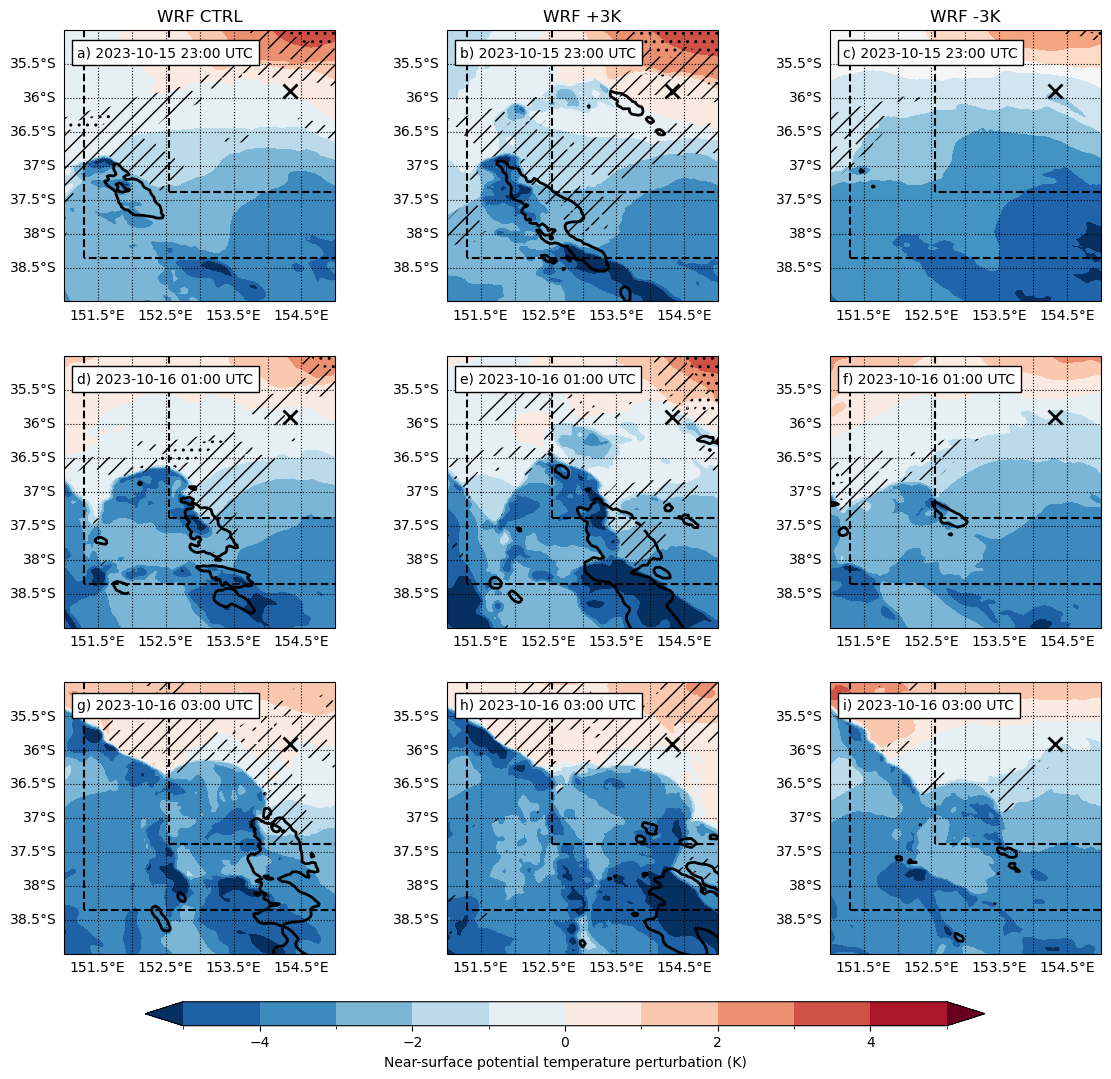

In [52]:
wrflist = wrflist_d02; step = 5    

plt.figure(figsize = [14,12] )
cnt1=0
times=[8,10,12]
cols=3
letters = ["a","b","c","d","e","f","g","h","i"]
for t in tqdm.tqdm(times):
    cnt2=1
    for wrflist,title in zip([wrflist_d02,wrflist_d02_plus,wrflist_d02_minus],["WRF CTRL","WRF +3K","WRF -3K"]):
        ax = plt.subplot(len(times), cols, (cnt1*cols)+cnt2,projection=ccrs.PlateCarree())

        ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
        wrf_proj = wrf.get_cartopy(ctt)
        uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
        u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
        v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
        lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
        lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
        theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
        qr = wrf.getvar(wrflist[t], "QRAIN").isel(bottom_top=0)*1000
        Wmin = wrf.getvar(wrflist[t], "W").min("bottom_top_stag")
        Wmax = wrf.getvar(wrflist[t], "W").max("bottom_top_stag")

        #ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
        xr.plot.contour(ctt,ax=ax,colors=["k"],levels=[230],x="XLONG",y="XLAT",linewidths=[2])
        #xr.plot.contour(calc_grad_theta(theta),levels=[0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
        c=xr.plot.contourf(theta-theta.mean(),levels=11,x="XLONG",y="XLAT",alpha=1,cmap="RdBu_r",vmin=-5,vmax=5,add_colorbar=False)
        #xr.plot.contourf(qr,levels=11,x="XLONG",y="XLAT",alpha=1,cmap="Blues",vmin=0,vmax=2)        
        #xr.plot.contourf(Wmin,levels=[-2,-1.5,-1,-0.5,0],x="XLONG",y="XLAT",alpha=1,cmap="Blues_r")        
        #xr.plot.contour(Wmax,levels=[2],x="XLONG",y="XLAT",alpha=1,colors=["w"],linewidths=2)
        #plt.quiver(lon,lat,u10,v10,scale=200,width=0.004)    
        
        xr.plot.contourf(
            wrf.getvar(wrflist[t], "cape_2d").isel(mcape_mcin_lcl_lfc=0),
            colors=["none"],levels=[0,500,1000],hatches=["","//",".."],add_colorbar=False,x="XLONG",y="XLAT")



        plt.xlim([wrflist_d02[0]["XLONG"][:].min(),wrflist_d02[0]["XLONG"][:].max()])
        plt.ylim([wrflist_d02[0]["XLAT"][:].min(),wrflist_d02[0]["XLAT"][:].max()])
        d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
        d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
        d03_xlim = [wrflist_d03[0]["XLONG"][:].min(),wrflist_d03[0]["XLONG"][:].max()]
        d03_ylim = [wrflist_d03[0]["XLAT"][:].min(),wrflist_d03[0]["XLAT"][:].max()]    
        plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
        plt.plot([d03_xlim[0],d03_xlim[0],d03_xlim[1],d03_xlim[1],d03_xlim[0]], [d03_ylim[0],d03_ylim[1],d03_ylim[1],d03_ylim[0],d03_ylim[0]], color="k", ls="--")
        ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
        ax.coastlines()
        ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
        ax.text(0.05,0.9,letters[(cnt1*cols)+(cnt2-1)]+") "+pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})    
        ax.set_extent([151,155,-39,-35]) 
        
        if cnt1==0:
            plt.title(title)
        else:
            plt.title("")
        
        cnt2=cnt2+1

    cnt1=cnt1+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Near-surface potential temperature perturbation (K)")    

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/wrf_mcs_comparison.jpeg",dpi=500,bbox_inches="tight")